In [1]:
import os, json
from IPython.display import Image
import openai
from azure.storage.blob import BlobServiceClient

import utils
from dotenv import load_dotenv
load_dotenv(".env")

True

### SET VARIABLES

In [2]:
use_azure_active_directory = False  # Set this flag to True if you are using Azure Active Directory
if not use_azure_active_directory:
    aoai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
    aoai_api_key = os.environ["AZURE_OPENAI_API_KEY"]
    api_version = os.environ["AZURE_OPENAI_API_VERSION"]

    aoai_endpoint_4v = os.environ["AZURE_OPENAI_ENDPOINT_4V"]
    aoai_api_key_4v = os.environ["AZURE_OPENAI_API_KEY_4V"]
    api_version_4v = os.environ["AZURE_OPENAI_API_VERSION_4V"]

    client = openai.AzureOpenAI( 
        azure_endpoint=aoai_endpoint,
        api_key=aoai_api_key,
        api_version= api_version
    )
    
embedding_model: str = "text-embedding-ada-002" 
chat_model: str = "gpt-4-0125"

connection_string = os.environ["STORAGE_CONN_STR"]
# Temporarily set as identity access fails
storage_sas_token = os.environ["STORAGE_SAS_TOKEN"] 


### PERFORM A HYBRID SEARCH

In [3]:
import json
# Semantic Hybrid Search
#query = "What is the disposal of PET bottle?"  
query = "ご契約者が冬の円貨定期預金金利優遇キャンペーンを知る機会は何になりますか"
#query = "受電で対応できる来店予約は何ですか"

answer_context = []
results = utils.search_index(query, client, embedding_model)

for result in results:
    titles_and_content = {}
    titles_and_content["title"] = result["title"]
    titles_and_content["content"] = result["content"]
    #titles_and_content["reranking_score"] = result["@search.reranker_score"]
    answer_context.append(titles_and_content)

#print(json.dumps(answer_context, indent=4, ensure_ascii=False))

### RAG Query to GPT-4-turbo

In [4]:
with open("./system_message_02.txt", "r", encoding = 'utf-8') as f:
    system_message = f.read()

In [5]:
messages = []
messages.append({"role": "system","content": system_message})

content = {}
content["question"] = query
content["context"] = answer_context
messages.append({"role": "user", "content": str(content)})

#print(json.dumps(messages, indent=4, ensure_ascii=False))

In [6]:
response = utils.gpt4_turbo_query(messages, client, chat_model)
answer = response.choices[0].message.content

answer = json.loads(answer)
print(answer)

{'title': '冬キャンA4チラシ', 'page': '冬キャンA4チラシ_01', 'answer': 'ご契約者が冬の円貨定期預金金利優遇キャンペーンを知る機会は、冬キャンA4チラシによる情報提供になります。このチラシには、キャンペーンの詳細、期間、金利優遇の条件などが記載されており、三井住友信託銀行が提供する冬の円貨定期預金金利優遇キャンペーンの情報を広くお客様に知らせるための主要な手段となっています。また、本キャンペーンではアプリ「スマートライフデザイナー」のダウンロードが条件とされており、詳細はチラシの裏面のご注意事項で確認できます。'}


In [7]:
print(answer["answer"])

ご契約者が冬の円貨定期預金金利優遇キャンペーンを知る機会は、冬キャンA4チラシによる情報提供になります。このチラシには、キャンペーンの詳細、期間、金利優遇の条件などが記載されており、三井住友信託銀行が提供する冬の円貨定期預金金利優遇キャンペーンの情報を広くお客様に知らせるための主要な手段となっています。また、本キャンペーンではアプリ「スマートライフデザイナー」のダウンロードが条件とされており、詳細はチラシの裏面のご注意事項で確認できます。


### Get URL of the 'title' image

In [8]:
container_name = "manual-test"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_name = answer["page"]
split_word = "_"

image_urls = utils.list_blobs_titles_and_urls_ns(blob_service_client, container_name, blob_name, split_word)
image_urls


[{'title': '冬キャンA4チラシ_01.jpeg',
  'url': 'https://demostorage4search.blob.core.windows.net/manual-test/%E5%86%AC%E3%82%AD%E3%83%A3%E3%83%B3A4%E3%83%81%E3%83%A9%E3%82%B7_01.jpeg'},
 {'title': '冬キャンA4チラシ_02.jpeg',
  'url': 'https://demostorage4search.blob.core.windows.net/manual-test/%E5%86%AC%E3%82%AD%E3%83%A3%E3%83%B3A4%E3%83%81%E3%83%A9%E3%82%B7_02.jpeg'}]

## Sending a new message to GPT-4v

### Construct a new message with a single image

In [9]:
with open("./system_message_01.txt", "r", encoding = 'utf-8') as f:
    system_message = f.read()

In [10]:
messages = []
messages.append({"role": "system","content":[{"type": "text", "text": system_message}]})

content = []
content.append({"type": "text", "text": "query: " + query})
content.append({"type": "text", "text":"answer from gpt-4: " + answer["answer"]})

for url in image_urls:    # pick up the most relevant image
    storagepath = url['title']
    storagepath_stem = os.path.splitext(storagepath)[0]
    if not (storagepath_stem[-3] == split_word and storagepath_stem[-2:].isdigit()):
        storagepath_stem += split_word + '01' # storagepath doesn't have a number suffix
    if storagepath_stem == answer['page']:
        content.append({"type": "text", "text": storagepath})
        content.append({"type": "image_url", "image_url": url['url']+storage_sas_token})
        break

messages.append({"role": "user","content":content})

In [11]:
messages

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an AI assistant with vision capability that helps people find information.\nAnswer to the question only in the context of the given text and the images.\nRead the text and the images carefully, explain thoroughly what is relevant to the question.\nDo not answer using your knowledge.\nIf you didn\'t find the answer in the provided information, reply Not Found statement: \\"Sorry, Answer to the question cannot be found in the provided information.\\".\nYour Answer must be in the language of the question, including the Not Found statement.\n\n[About images]\nEach image has preceding answer from GPT-4 and the file name of the image. \nThe answer from GPT-4 may be incorrect as it doesn\'t have vision, but transcription would be correct.\nRefer to the file name with the extension as the citation in your answer.\nDon\'t have to add the term \\"image\\" or \\"画像\\" in the citation.\nAnswer to the question in the following 

### Ask gpt-4v

In [12]:
response = utils.gpt4v_query(messages, aoai_endpoint_4v, aoai_api_key_4v, api_version_4v)
#answer = response.json()["choices"][0]["message"]["content"]
answer = response.json()["choices"][0]["enhancements"]["grounding"]["lines"][0]["text"]
print(answer)

ご契約者が冬の円貨定期預金金利優遇キャンペーンを知る機会は、冬キャンA4チラシによる情報提供になります。このチラシには、キャンペーンの詳細、期間、金利優遇の条件などが記載されており、三井住友信託銀行が提供する冬の円貨定期預金金利優遇キャンペーンの情報を広くお客様に知らせるための主要な手段となっています。また、本キャンペーンではアプリ「スマートライフデザイナー」のダウンロードが条件とされており、詳細はチラシの裏面のご注意事項で確認できます。
冬キャンA4チラシ_01.jpeg


In [13]:
response.json()["choices"][0]

{'finish_reason': 'stop',
 'index': 0,
 'message': {'role': 'assistant',
  'content': 'ご契約者が冬の円貨定期預金金利優遇キャンペーンを知る機会は、冬キャンA4チラシによる情報提供になります。このチラシには、キャンペーンの詳細、期間、金利優遇の条件などが記載されており、三井住友信託銀行が提供する冬の円貨定期預金金利優遇キャンペーンの情報を広くお客様に知らせるための主要な手段となっています。また、本キャンペーンではアプリ「スマートライフデザイナー」のダウンロードが条件とされており、詳細はチラシの裏面のご注意事項で確認できます。\n冬キャンA4チラシ_01.jpeg'},
 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
  'self_harm': {'filtered': False, 'severity': 'safe'},
  'sexual': {'filtered': False, 'severity': 'safe'},
  'violence': {'filtered': False, 'severity': 'safe'}},
 'enhancements': {'grounding': {'lines': [{'text': 'ご契約者が冬の円貨定期預金金利優遇キャンペーンを知る機会は、冬キャンA4チラシによる情報提供になります。このチラシには、キャンペーンの詳細、期間、金利優遇の条件などが記載されており、三井住友信託銀行が提供する冬の円貨定期預金金利優遇キャンペーンの情報を広くお客様に知らせるための主要な手段となっています。また、本キャンペーンではアプリ「スマートライフデザイナー」のダウンロードが条件とされており、詳細はチラシの裏面のご注意事項で確認できます。\n冬キャンA4チラシ_01.jpeg',
     'spans': []}],
   'status': 'Success'}}}

### Download and show the image

Download Image: 冬キャンA4チラシ_01.jpeg


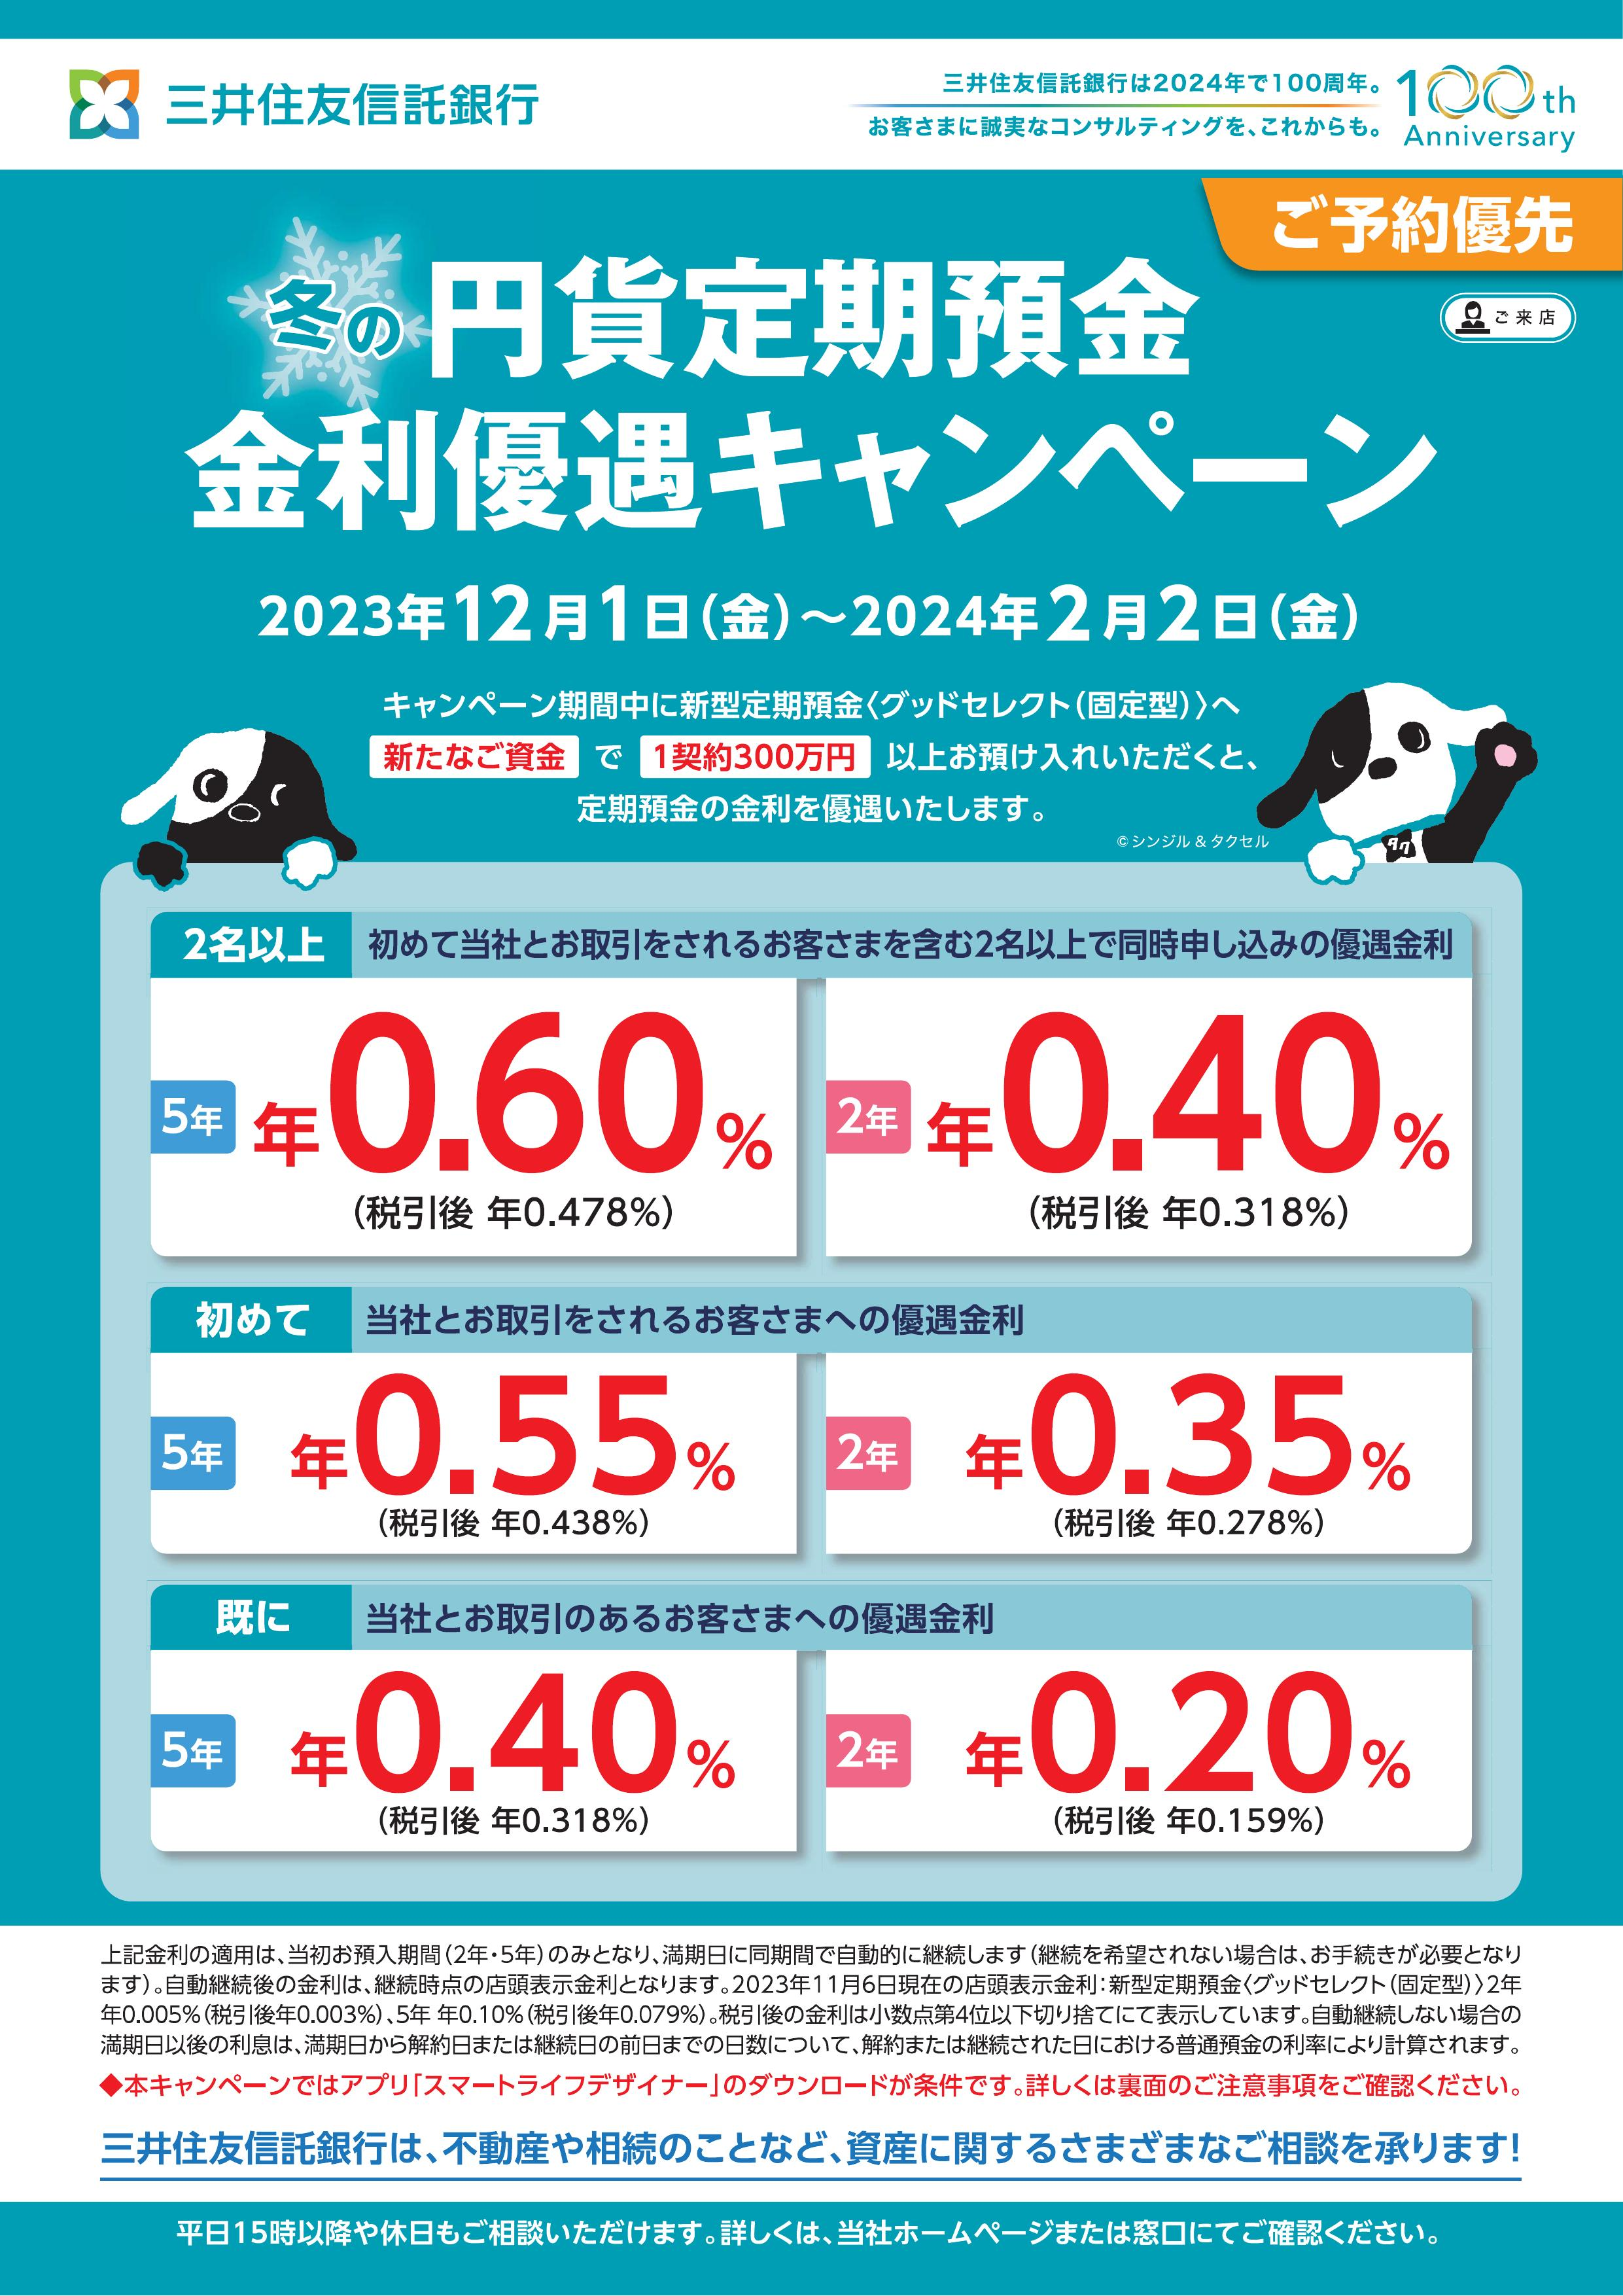

In [14]:
utils.list_blobs_download(blob_service_client, container_name, storagepath)
display(Image(filename=storagepath))

## Maintain the massage

In [14]:
utils.append_conversation_history(messages, response, role="assistant")
print(messages)

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an AI assistant with vision capability that helps people find information.\nAnswer to the question only in the context of the given text and the images.\nRead the text and the images carefully, explain thoroughly what is relevant to the question.\nDo not answer using your knowledge.\nIf you didn\'t find the answer in the provided information, reply Not Found statement: \\"Sorry, Answer to the question cannot be found in the provided information.\\".\nYour Answer must be in the language of the question, including the Not Found statement.\n\n[About images]\nEach image has preceding file name. Refer to the file name with the extension as the citation in your answer.\nDon\'t have to add the term \\"image\\" or \\"画像\\" in the citation.\nAnswer to the question in the following format.\n{"answer"}\n "<your first answer with full explanation>"\n{"citation"}\n "<fine name relevant to the answer>"\n'}]}, {'role': 'user', 'content

### Send the consecutive query

In [15]:
messages.append({"role": "user","content":[
    {"type": "text", "text": "ponta ポイントサービスについて教えてください。"}, 
]})
response = utils.gpt4v_query(messages, aoai_endpoint, aoai_api_key, api_version)
print(response.json()["choices"][0]["message"]["content"])

{"answer"}
 "Sorry, Answer to the question cannot be found in the provided information."
{"citation"}
 "福岡市事業系ごみ.jpg"


## Backup script

Download all the images that include a page relevant to the questions

In [ ]:
for url in image_urls:
    utils.list_blobs_download(blob_service_client, container_name, url['title'])
    display(Image(filename=url['title']))

Download Images

In [ ]:
utils.list_blobs_download(blob_service_client, container_name, blob_name, split_word)

List the urls of the images

In [ ]:
image_urls = utils.list_blobs_urls(blob_service_client, container_name, blob_name, split_word)
print(image_urls)

List the urls relevant to the query

In [ ]:
image_urls_list = []
for result in results:
    image_urls_list += utils.list_blobs_urls(blob_service_client, container_name, result['title'], split_word)
    #image_urls_list.append(image_urls)

print(image_urls_list)

### END OF SCRIPT